In [ ]:
# Basic data manipulations
import pandas as pd
import numpy as np


# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
! pip install torchsummary
import torchsummary



# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Pytorch way of data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
root_path = '/drive/input/defungi'
df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
label_dict = {
    "H1":0,
    "H2":1,
    "H3":2,
    "H5":3,
    "H6":4,
}
for key in label_dict:
    img_path = os.path.join(root_path, key)
    jpg_list = glob(img_path+'/*.jpg')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":key, "class_id":label_dict[key]}, index=[1])
        df = pd.concat([df, new_data], ignore_index=True)

df[["path"]] = df[["path"]].astype(str)
df[["label"]] = df[["label"]].astype(str)
df[["class_id"]] = df[["class_id"]].astype(int)

In [ ]:
train_transforms = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.RandomErasing(p=0.5, scale=(0.1,0.15)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

test_transforms = v2.Compose([
    v2.Resize((224,224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_):
        self.df = dataframe
        self.transforms_ = transforms_

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_path = self.df.iloc[index]['path']

        img = Image.open(image_path).convert("RGB")

        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img, class_id

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
num_workers = 2 if device=='cuda' else 4

train_df, val_df = train_test_split(df,test_size=0.2)
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [ ]:
dataiter = iter(train_loader)

images,labels = next(dataiter)

print(type(images))

print(images.shape)

<class 'torch.Tensor'>
torch.Size([8, 3, 224, 224])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = SimpleCNN()

print(model)


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0
    for (data_,target_) in dataloader:
        target_ = target_.type(torch.LongTensor)
        data_, target_ = data_.to(device), target_.to(device)


        optimizer.zero_grad()


        outputs = model(data_)


        loss = criterion(outputs,target_)


        loss.backward()


        optimizer.step()


        epoch_loss = epoch_loss + loss.item()
        _,pred = torch.max(outputs,dim=1)
        epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    return epoch_correct/size, epoch_loss/num_batches

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    epoch_loss = 0.0
    epoch_correct = 0
    with torch.no_grad():

        model.eval()
        for (data_,target_) in dataloader:
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(device), target_.to(device)


            outputs = model(data_)


            loss = criterion(outputs,target_)

            epoch_loss = epoch_loss + loss.item()
            _,pred = torch.max(outputs,dim=1)
            epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    return  epoch_correct/size, epoch_loss/num_batches

In [ ]:
model.to(device)
EPOCHS = 50

logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

criterion  = nn.CrossEntropyLoss()
learning_rate = 0.0001
momentum = 0.9
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss,  = train(train_loader, model, criterion, optimizer)
    val_acc, val_loss = test(val_loader, model, criterion)
    print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f}')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)
    torch.save(model.state_dict(), "last.pth")

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 0     train_loss: 3.4631, train_acc: 0.508     val_loss: 1.0486, val_acc: 0.579


  2%|▏         | 1/50 [02:36<2:08:12, 156.99s/it]

EPOCH: 1     train_loss: 1.0680, train_acc: 0.571     val_loss: 1.0245, val_acc: 0.575


  4%|▍         | 2/50 [04:08<1:34:57, 118.71s/it]

EPOCH: 2     train_loss: 1.0331, train_acc: 0.583     val_loss: 0.9439, val_acc: 0.626


  6%|▌         | 3/50 [05:42<1:23:55, 107.14s/it]

EPOCH: 3     train_loss: 1.0194, train_acc: 0.593     val_loss: 1.0026, val_acc: 0.589


  8%|▊         | 4/50 [07:14<1:17:43, 101.37s/it]

EPOCH: 4     train_loss: 0.9906, train_acc: 0.598     val_loss: 0.9309, val_acc: 0.625


 10%|█         | 5/50 [08:47<1:13:37, 98.17s/it] 

EPOCH: 5     train_loss: 0.9922, train_acc: 0.593     val_loss: 0.8931, val_acc: 0.627


 12%|█▏        | 6/50 [10:20<1:10:44, 96.47s/it]

EPOCH: 6     train_loss: 0.9724, train_acc: 0.602     val_loss: 0.9818, val_acc: 0.605


 14%|█▍        | 7/50 [11:52<1:08:09, 95.11s/it]

EPOCH: 7     train_loss: 0.9634, train_acc: 0.609     val_loss: 0.9233, val_acc: 0.624


 16%|█▌        | 8/50 [13:24<1:05:54, 94.16s/it]

EPOCH: 8     train_loss: 0.9322, train_acc: 0.617     val_loss: 0.9094, val_acc: 0.637


 18%|█▊        | 9/50 [14:57<1:03:54, 93.52s/it]

EPOCH: 9     train_loss: 0.9312, train_acc: 0.618     val_loss: 0.8883, val_acc: 0.640


 20%|██        | 10/50 [16:29<1:02:11, 93.30s/it]

EPOCH: 10     train_loss: 0.9195, train_acc: 0.616     val_loss: 0.8839, val_acc: 0.642


 22%|██▏       | 11/50 [18:02<1:00:25, 92.97s/it]

EPOCH: 11     train_loss: 0.9146, train_acc: 0.620     val_loss: 0.9241, val_acc: 0.632


 24%|██▍       | 12/50 [19:34<58:44, 92.74s/it]  

EPOCH: 12     train_loss: 0.9058, train_acc: 0.627     val_loss: 0.9450, val_acc: 0.595


 26%|██▌       | 13/50 [21:07<57:13, 92.79s/it]

EPOCH: 13     train_loss: 0.8998, train_acc: 0.631     val_loss: 0.9152, val_acc: 0.626


 28%|██▊       | 14/50 [22:40<55:45, 92.94s/it]

EPOCH: 14     train_loss: 0.8897, train_acc: 0.630     val_loss: 0.8496, val_acc: 0.638


 30%|███       | 15/50 [24:12<54:05, 92.72s/it]

EPOCH: 15     train_loss: 0.8764, train_acc: 0.637     val_loss: 0.8191, val_acc: 0.659


 32%|███▏      | 16/50 [25:46<52:40, 92.96s/it]

EPOCH: 16     train_loss: 0.8757, train_acc: 0.637     val_loss: 0.8874, val_acc: 0.642


 34%|███▍      | 17/50 [27:19<51:10, 93.04s/it]

EPOCH: 17     train_loss: 0.8568, train_acc: 0.642     val_loss: 0.8174, val_acc: 0.665


 36%|███▌      | 18/50 [28:51<49:30, 92.84s/it]

EPOCH: 18     train_loss: 0.8513, train_acc: 0.647     val_loss: 0.8182, val_acc: 0.664


 38%|███▊      | 19/50 [30:25<48:03, 93.02s/it]

EPOCH: 19     train_loss: 0.8612, train_acc: 0.642     val_loss: 0.7903, val_acc: 0.672


 40%|████      | 20/50 [31:57<46:28, 92.95s/it]

EPOCH: 20     train_loss: 0.8548, train_acc: 0.642     val_loss: 0.8236, val_acc: 0.663


 42%|████▏     | 21/50 [33:30<44:55, 92.94s/it]

EPOCH: 21     train_loss: 0.8409, train_acc: 0.646     val_loss: 0.8030, val_acc: 0.671


 44%|████▍     | 22/50 [35:03<43:18, 92.79s/it]

EPOCH: 22     train_loss: 0.8380, train_acc: 0.648     val_loss: 0.7954, val_acc: 0.662


 46%|████▌     | 23/50 [36:36<41:46, 92.84s/it]

EPOCH: 23     train_loss: 0.8386, train_acc: 0.650     val_loss: 0.8359, val_acc: 0.664


 48%|████▊     | 24/50 [38:08<40:10, 92.73s/it]

EPOCH: 24     train_loss: 0.8237, train_acc: 0.662     val_loss: 0.7652, val_acc: 0.681


 50%|█████     | 25/50 [39:40<38:34, 92.57s/it]

EPOCH: 25     train_loss: 0.8221, train_acc: 0.655     val_loss: 0.7756, val_acc: 0.675


 52%|█████▏    | 26/50 [41:13<36:58, 92.43s/it]

EPOCH: 26     train_loss: 0.8273, train_acc: 0.658     val_loss: 0.9118, val_acc: 0.611


 54%|█████▍    | 27/50 [42:45<35:26, 92.45s/it]

EPOCH: 27     train_loss: 0.8202, train_acc: 0.662     val_loss: 0.8314, val_acc: 0.631


 56%|█████▌    | 28/50 [44:17<33:50, 92.28s/it]

EPOCH: 28     train_loss: 0.8178, train_acc: 0.660     val_loss: 0.7822, val_acc: 0.672


 58%|█████▊    | 29/50 [45:49<32:19, 92.34s/it]

EPOCH: 29     train_loss: 0.8154, train_acc: 0.658     val_loss: 0.8047, val_acc: 0.657


 58%|█████▊    | 29/50 [47:22<34:18, 98.01s/it]

Earlystop!


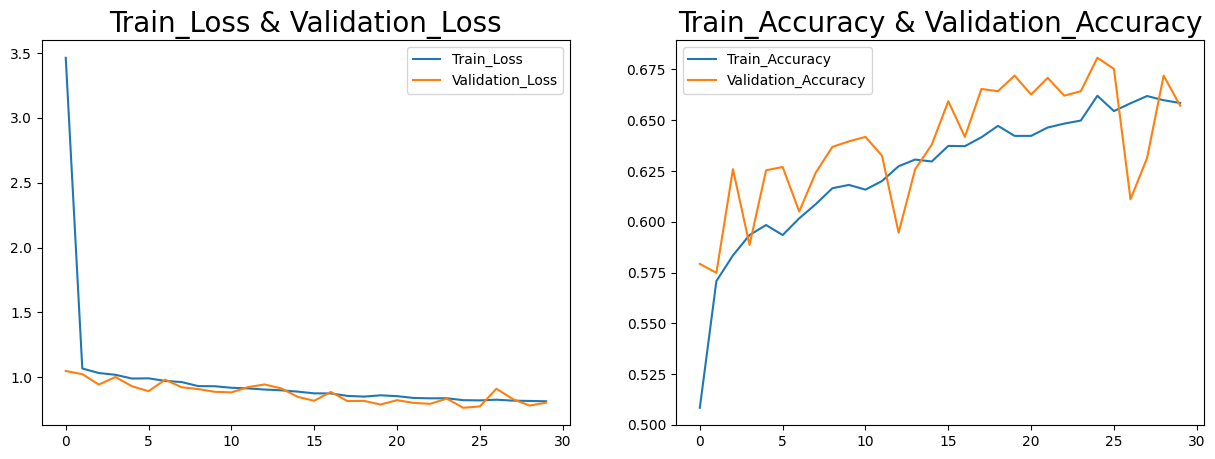

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_acc'],label='Train_Accuracy')
plt.plot(logs['val_acc'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()